## Manifold Learning

* https://jakevdp.github.io/PythonDataScienceHandbook/05.10-manifold-learning.html

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import os
import sys
p = os.path.join(os.path.dirname('__file__'), '..')
sys.path.append(p)
from common import *
sns.set()

Manifold Learning
* Dimensionality reduction technique
* Given high-dimensional data, it seeks a low-dimensional representation of the data that preserves certain relationships within the data.

Use cases
* Good for nonlinear relationships (PCA fails)

Manifold
*  Imagine a sheet of paper: this is a two-dimensional object that lives in our familiar three-dimensional world, and can be bent or rolled in two dimensions. 
* We can think of this sheet as a two-dimensional manifold embedded in three-dimensional space.
* Rotating, re-orienting, or stretching the piece of paper in three-dimensional space doesn't change the flat geometry of the paper: such operations are akin to linear embeddings. 
* If you bend, curl, or crumple the paper, it is still a two-dimensional manifold, but the embedding into the three-dimensional space is no longer linear. 

Algorithms
* MDS (multi-dimensional scaling)
    * Quantity preserved is the distance between every pair of points
* LLE (locally linear embedding)
* IsoMap (isometric mapping)

### Data

In [2]:
def make_hello(N=1000, rseed=42):
    # Make a plot with "HELLO" text; save as PNG
    fig, ax = plt.subplots(figsize=(4, 1))
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
    ax.axis('off')
    ax.text(0.5, 0.4, 'HELLO', va='center', ha='center', weight='bold', size=85)
    fig.savefig('hello.png')
    plt.close(fig)
    
    # Open this PNG and draw random points from it
    from matplotlib.image import imread
    data = imread('hello.png')[::-1, :, 0].T
    rng = np.random.RandomState(rseed)
    X = rng.rand(4 * N, 2)
    i, j = (X * data.shape).astype(int).T
    mask = (data[i, j] < 1)
    X = X[mask]
    X[:, 0] *= (data.shape[0] / data.shape[1])
    X = X[:N]
    return X[np.argsort(X[:, 0])]

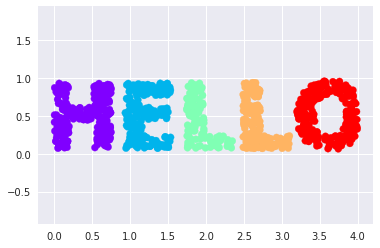

In [3]:
X = make_hello(1000)
colorize = dict(c=X[:, 0], cmap=plt.cm.get_cmap('rainbow', 5))
plt.scatter(X[:, 0], X[:, 1], **colorize)
plt.axis('equal');

### MDS (Multidimensional Scaling)

* Quantity preserved is the distance between every pair of points.
* Doesn't work for nonlinear embeddings

* For rigid body transforms (translate, rotate, scale), the relationship between points (distance) doesn't change

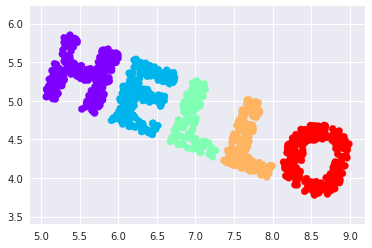

In [6]:
def rotate(X, angle):
    theta = np.deg2rad(angle)
    R = [[np.cos(theta), -np.sin(theta)],
         [np.sin(theta), np.cos(theta)]]
    return np.dot(X, R)
    
X2 = rotate(X, 20) + 5
plt.scatter(X2[:, 0], X2[:, 1], **colorize)
plt.axis('equal');

So lets figure out the distance between points using <b>pairwise distance</b>

Pairwise Distance Matrix
* For N points, we construct an N by N array such that entry (i, j) contains the distance between point i and point j. 

In [7]:
from sklearn.metrics import pairwise_distances
D = pairwise_distances(X)
D.shape

(1000, 1000)

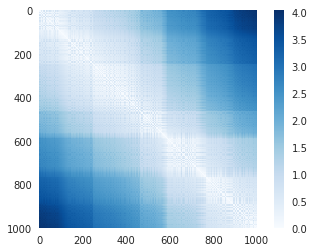

In [8]:
plt.imshow(D, zorder=2, cmap='Blues', interpolation='nearest')
plt.colorbar();

Given a distance matrix between points, MDS recovers a D-dimensional coordinate representation of the data.

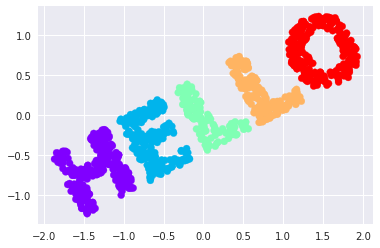

In [9]:
from sklearn.manifold import MDS
model = MDS(n_components=2, dissimilarity='precomputed', random_state=1)
out = model.fit_transform(D)
plt.scatter(out[:, 0], out[:, 1], **colorize)
plt.axis('equal');

So MDS can recover the datapoints given only a pairwise distance matrix

Why is this useful?
* It works for any number of dimensions...

In [10]:
# Let's project to 3D
def random_projection(X, dimension=3, rseed=42):
    assert dimension >= X.shape[1]
    rng = np.random.RandomState(rseed)
    C = rng.randn(dimension, dimension)
    e, V = np.linalg.eigh(np.dot(C, C.T))
    return np.dot(X, V[:X.shape[1]])
    
X3 = random_projection(X, 3)
X3.shape

(1000, 3)

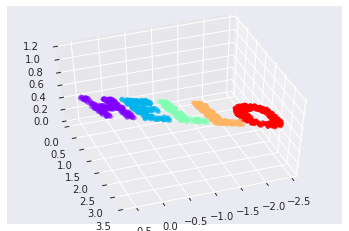

In [11]:
from mpl_toolkits import mplot3d
ax = plt.axes(projection='3d')
ax.scatter3D(X3[:, 0], X3[:, 1], X3[:, 2],
             **colorize)
ax.view_init(azim=70, elev=50)

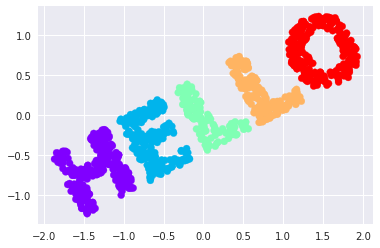

In [12]:
model = MDS(n_components=2, random_state=1)
out3 = model.fit_transform(X3)
plt.scatter(out3[:, 0], out3[:, 1], **colorize)
plt.axis('equal');

This is essentially the goal of a manifold learning estimator: given high-dimensional embedded data, it seeks a low-dimensional representation of the data that preserves certain relationships within the data. In the case of MDS, the quantity preserved is the distance between every pair of points.

### LLE (Locally Linear Embedding)

* MDS fails for nonlinear datasets, like this one
* LLE solves this by relaxing the constraint on preserving distance between far away points
* It focuses instead on preserving distance between nearby points

![](https://jakevdp.github.io/PythonDataScienceHandbook/figures/05.10-LLE-vs-MDS.png)

* MDS: tries to preserve the distances between each pair of points in the dataset
* LLE: rather than preserving all distances, it instead tries to preserve only the distances between neighboring points: in this case, the nearest 100 neighbors of each point.

In [13]:
def make_hello_s_curve(X):
    t = (X[:, 0] - 2) * 0.75 * np.pi
    x = np.sin(t)
    y = X[:, 1]
    z = np.sign(t) * (np.cos(t) - 1)
    return np.vstack((x, y, z)).T

XS = make_hello_s_curve(X)

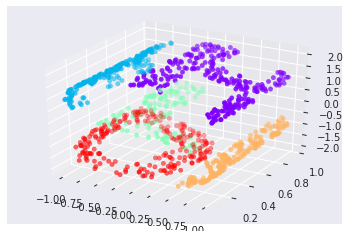

In [14]:
from mpl_toolkits import mplot3d
ax = plt.axes(projection='3d')
ax.scatter3D(XS[:, 0], XS[:, 1], XS[:, 2],
             **colorize);

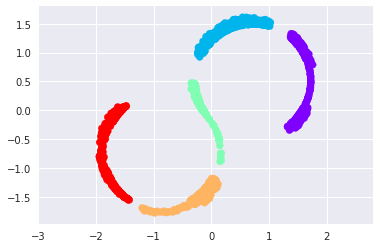

In [15]:
# Manifold Learning Fails to recover Hello (when it's warped in a non-linear way)
from sklearn.manifold import MDS
model = MDS(n_components=2, random_state=2)
outS = model.fit_transform(XS)
plt.scatter(outS[:, 0], outS[:, 1], **colorize)
plt.axis('equal');

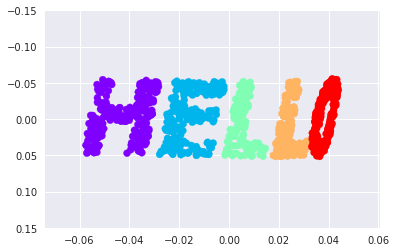

In [17]:
# LLE recovers Hello from the non-linearly distored representatino in higher dimensions
from sklearn.manifold import LocallyLinearEmbedding
model = LocallyLinearEmbedding(n_neighbors=100, n_components=2, method='modified',
                               eigen_solver='dense')
out = model.fit_transform(XS)

fig, ax = plt.subplots()
ax.scatter(out[:, 0], out[:, 1], **colorize)
ax.set_ylim(0.15, -0.15);

### Summary

* Manifold learning techniques are rarely used in practice 
* Use cases
    * Visualization of high-dimensional data
* Pros
    * Preserve non-linear relationships in the data
* Cons
    * Don't handle noise very well
    * Need to choose optimal # of neighbors
    * Computationally expensive (n^2 or n^3)

### Links

* http://scikit-learn.org/stable/modules/manifold.html
* https://jakevdp.github.io/PythonDataScienceHandbook/05.10-manifold-learning.html